# Warehouse Storage Optimization

## 1. Storage Location Assignment

### Distance Matrix and Weights




In [31]:
import pandas as pd

# Required storage spaces needed data S_i
storage_spaces = {"A" : 3, "B" : 5, "C" : 2, "D" : 6}
total_spaces = sum(storage_spaces.values())

# Frequency of trips data f_ik
frequency = {"IO Point 1" : {"A" : 150, "B" : 60, "C" : 96, "D" : 175},
            "IO Point 2" : {"A" : 25, "B" : 200, "C" : 15, "D" : 135},
            "IO Point 3" : {"A" : 88, "B" : 150, "C" : 85, "D" : 90},
}
frequency_df = pd.DataFrame(frequency).loc[["A", "B", "C", "D"]]

# Cost data c_ik
cost = {"IO Point 1" : {"A" : 6, "B" : 7, "C" : 4, "D" : 15},
        "IO Point 2" : {"A" : 5, "B" : 3, "C" : 7, "D" : 8},
        "IO Point 3" : {"A" : 5, "B" : 6, "C" : 9, "D" : 12},
}
cost_df = pd.DataFrame(cost).loc[["A", "B", "C", "D"]]

# Define the IO points coordinates
io_points = {1: (2.5, 0.5), 2: (0.5, 2.5), 3: (2.5, 4.5)}

storage_locations = {}
idx = 1
for y in range(4, 0, -1):
    for x in range(1,5):
        storage_locations[idx] = (x, y)
        idx += 1

#print(storage_locations)

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

# Calculate distance matrix d_kj
distance_matrix = pd.DataFrame(index=io_points.keys(), columns=storage_locations.keys())

for k, io_coord in io_points.items():
    for j, storage_coord in storage_locations.items():
        distance_matrix.loc[k, j] = manhattan_distance(io_coord, storage_coord)

print("Distance Matrix (d_kj): \n")
print(distance_matrix)

items = ["A", "B", "C", "D"]
weights_matrix = pd.DataFrame(index=items, columns=storage_locations.keys())

for i in items:
    for j in storage_locations.keys():
        total_weight = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            total_weight += f_ik * (c_ik + d_kj)
        weights_matrix.loc[i, j] = total_weight / total_spaces

print("Weight matrix w_ij (items × storage locations):")
print(weights_matrix)

Distance Matrix (d_kj): 

    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  \
1  5.0  4.0  4.0  5.0  4.0  3.0  3.0  4.0  3.0  2.0  2.0  3.0  2.0  1.0  1.0   
2  2.0  3.0  4.0  5.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0  2.0  3.0  4.0   
3  2.0  1.0  1.0  2.0  3.0  2.0  2.0  3.0  4.0  3.0  3.0  4.0  5.0  4.0  4.0   

    16  
1  2.0  
2  5.0  
3  5.0  
Weight matrix w_ij (items × storage locations):
         1        2         3         4        5         6         7   \
A  152.5625   139.25  140.8125    157.25  147.125  133.8125   135.375   
B     182.5  181.875   194.375     220.0  175.625     175.0     187.5   
C   120.875    110.5  111.4375  123.6875   119.25   108.875  109.8125   
D   381.875   373.75  382.1875  407.1875  368.125     360.0  368.4375   

         8         9         10       11        12        13        14  \
A  151.8125    143.25  129.9375    131.5  147.9375  140.9375   127.625   
B   213.125    181.25   180.625  193.125    218.75   19

### Mathematical Model (SLAP)

Weight matrix w_ij (items x storage locations):
         1        2         3         4        5         6         7   \
A  152.5625   139.25  140.8125    157.25  147.125  133.8125   135.375   
B     182.5  181.875   194.375     220.0  175.625     175.0     187.5   
C   120.875    110.5  111.4375  123.6875   119.25   108.875  109.8125   
D   381.875   373.75  382.1875  407.1875  368.125     360.0  368.4375   

         8         9         10       11        12        13        14  \
A  151.8125    143.25  129.9375    131.5  147.9375  140.9375   127.625   
B   213.125    181.25   180.625  193.125    218.75   199.375    198.75   
C  122.0625  118.5625  108.1875  109.125   121.375  118.8125  108.4375   
D  393.4375  362.8125  354.6875  363.125   388.125  365.9375  357.8125   

         15       16  
A  129.1875  145.625  
B    211.25  236.875  
C   109.375  121.625  
D    366.25   391.25  
Cost matrix (items x storage locations):
        1        2        3        4        5        6     

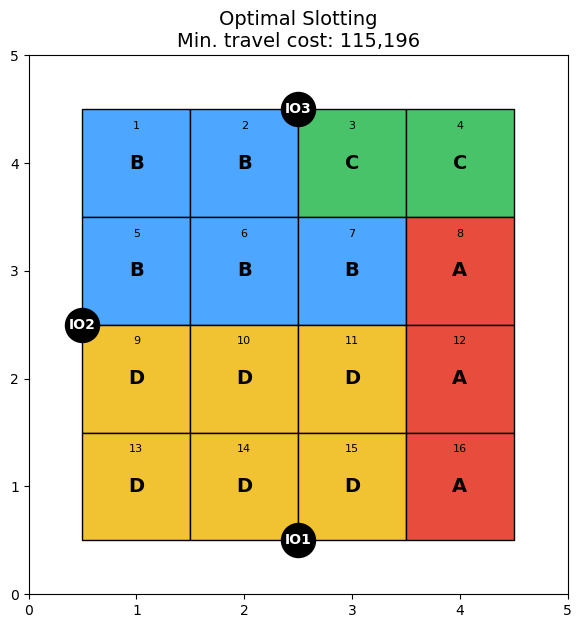

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

items = list(storage_spaces.keys())
weights_matrix = pd.DataFrame(index=items, columns=storage_locations.keys())
for i in items:
    for j in storage_locations.keys():
        total_weight = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            total_weight += f_ik * (c_ik + d_kj)
        weights_matrix.loc[i, j] = total_weight / total_spaces

print("Weight matrix w_ij (items x storage locations):")
print(weights_matrix)

# Grid and centers
slots = {}
n = 1
for y in range(4, 0, -1):
    for x in range(1, 5):
        slots[n] = (x, y)
        n += 1

centers = {s: (x - 0.5, y - 0.5) for s, (x, y) in slots.items()}

# I/O coordinates
io_coords = {
    1: (2.5, 0.5),   # IO1
    2: (0.5, 2.5),   # IO2
    3: (2.5, 4.5),   # IO3
}

# Building cost matrix
slot_list = list(storage_locations.keys())   # slots 1..16

cost_matrix = pd.DataFrame(index=items, columns=slot_list, dtype=float)
for i in items:
    for j in slot_list:
        total_cost = 0
        for k in io_points.keys():
            f_ik = frequency_df.loc[i, f"IO Point {k}"]
            c_ik = cost_df.loc[i, f"IO Point {k}"]
            d_kj = distance_matrix.loc[k, j]
            total_cost += f_ik * c_ik * d_kj
        cost_matrix.loc[i, j] = total_cost

print("Cost matrix (items x storage locations):")
print(cost_matrix)

# Solve SLAP by using Dynamic Programming
item_list = list(storage_spaces.keys())
num_items = len(item_list)
Q = [storage_spaces[item] for item in item_list]

dp = {tuple([0]*num_items): 0.0}
parent = {}

for idx, slot in enumerate(slot_list, start=1):
    best_cost = {}
    for state, cost_so_far in dp.items():
        for item_idx, item in enumerate(item_list):
            if state[item_idx] < Q[item_idx]:
                ns = list(state)
                ns[item_idx] += 1
                ns_tuple = tuple(ns)
                new_cost = cost_so_far + cost_matrix.loc[item, slot]
                if ns_tuple not in best_cost or new_cost < best_cost[ns_tuple]:
                    best_cost[ns_tuple] = new_cost
                    parent[(idx, ns_tuple)] = (state, item, slot)
    dp = best_cost

final_state = tuple(Q)
optimal_cost = dp[final_state]

# Final assignment of items to slots
assignment = {s: None for s in S}
cur_state = final_state
for idx in range(len(S), 0, -1):
    key = (idx, cur_state)
    prev_state, item_assigned, slot_assigned = parent[key]
    assignment[slot_assigned] = item_assigned
    cur_state = prev_state

# Output
print("Optimal total travel cost:", int(optimal_cost))
print("Assigned counts:", dict(Counter(assignment.values())))
print("Slot -> Item assignment:")
for s in slot_list:
    print(s, ":", assignment[s])

# Plotting
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D": "#f1c232"}

fig, ax = plt.subplots(figsize=(7, 7))

# Draw storage slots
for s, (x, y) in slots.items():
    item = assignment[s]
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                              facecolor=colors[item],
                               edgecolor="black"))
    ax.text(x, y, item, ha="center", va="center", fontsize=14, weight="bold")
    ax.text(x, y+0.3, str(s), ha="center", va="bottom", fontsize=8)

# Draw IO points
for p, (ix, iy) in io_coords.items(): 
    ax.scatter(ix, iy, s=600, c="black", zorder=6) 
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center", 
            fontsize=10, fontweight="bold", zorder=7)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect("equal")
plt.title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)
plt.show()


Optimal total travel cost: 115196
Assigned counts: {'B': 5, 'C': 2, 'A': 3, 'D': 6}
Slot -> Item assignment:
1 : B
2 : B
3 : C
4 : C
5 : B
6 : B
7 : B
8 : A
9 : D
10 : D
11 : D
12 : A
13 : D
14 : D
15 : D
16 : A


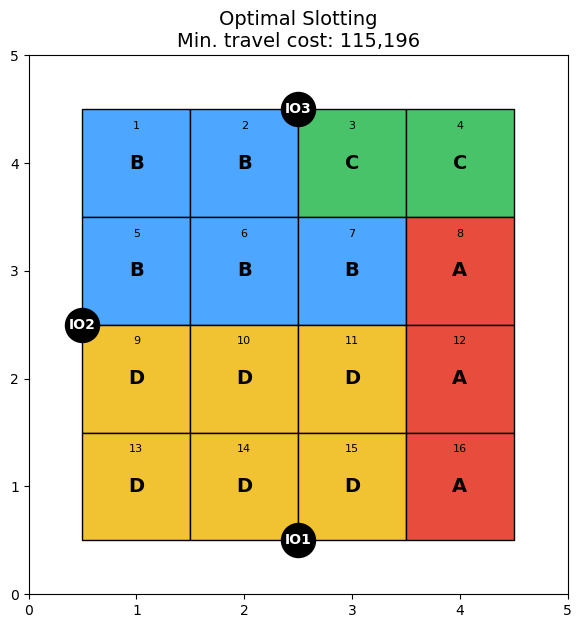

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pulp


# Solve SLAP by using MILP

# Decision variable x[i][j] ∈ {0,1} whether item i is assigned to slot j
x = pulp.LpVariable.dicts("x", (items, slot_list), cat="Binary")

prob = pulp.LpProblem("Slotting_MILP", pulp.LpMinimize)

# Objective: minimize sum(cost_matrix[i,j] * x[i,j])
prob += pulp.lpSum(cost_matrix.loc[i, j] * x[i][j] for i in items for j in slot_list)

# Constraint 1: each slot j must be assigned exactly one item
for j in slot_list:
    prob += pulp.lpSum(x[i][j] for i in items) == 1

# Constraint 2: each item i must occupy exactly storage_spaces[i] slots
for i in items:
    prob += pulp.lpSum(x[i][j] for j in slot_list) == storage_spaces[i]

# Solve (CBC solver included with pulp). Set msg=1 if you want solver output.
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# Check solver status
status = pulp.LpStatus[prob.status]
if status != "Optimal":
    raise RuntimeError(f"Solver did not return optimal status: {status}")

optimal_cost = pulp.value(prob.objective)

# Final assigment of items to slots
assignment = {}
for j in slot_list:
    assigned = None
    for i in items:
        if pulp.value(x[i][j]) is not None and pulp.value(x[i][j]) > 0.5:
            assigned = i
            break
    if assigned is None:
        raise RuntimeError(f"No item assigned to slot {j} by solver")
    assignment[j] = assigned

# Output
print("Optimal total travel cost:", int(optimal_cost))
print("Assigned counts:", dict(Counter(assignment.values())))
print("Slot -> Item assignment:")
for s in slot_list:
    print(s, ":", assignment[s])

# Plotting
colors = {"A": "#e74c3c", "B": "#4da6ff", "C": "#49c36a", "D": "#f1c232"}

fig, ax = plt.subplots(figsize=(7, 7))

# Draw storage slots
for s, (x, y) in slots.items():
    item = assignment[s]
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 1, 1,
                              facecolor=colors[item], edgecolor="black"))
    ax.text(x, y, item, ha="center", va="center", fontsize=14, weight="bold")
    ax.text(x, y+0.3, str(s), ha="center", va="bottom", fontsize=8)

# Draw IO points
for p, (ix, iy) in io_coords.items():
    ax.scatter(ix, iy, s=600, c="black", zorder=6)
    ax.text(ix, iy, f"IO{p}", color="white", ha="center", va="center",
            fontsize=10, fontweight="bold", zorder=7)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_aspect("equal")
plt.title(f"Optimal Slotting\nMin. travel cost: {int(optimal_cost):,}", fontsize=14)
plt.show()


Example optimal assignment (illustrative only):

```
Min. travel cost: 42,420
 ╔═════════════ I/O ═════╦═══════╗
 ║   A       A       A   ║   B   ║
 ╠═══════════════╦═══════╣       ║
 ║   D       D   ║   C   ║   B   ║
I/O              ║       ║       ║
 ║   D       D   ║   C   ║   B   ║
 ║               ╠═══════╝       ║
 ║   D       D   ║   B       B   ║
 ╚═════════════ I/O ═════════════╝
```

### 2. Random vs. Dedicated Policies

The answer comprises:

- Total storage for dedicated policy.
- Total storage for random policy.
- Reasoning behind the totals.

In [ ]:
import pandas as pd
import numpy as np

scheduled_receipts = {  "Period 1": {"A": 20, "B": 12,  "C": 66, "D": 22, "E": 97},
                        "Period 2": {"A": 15,  "B": 8, "C": 15, "D": 22, "E": 12},
                        "Period 3": {"A": 30,  "B": 4, "C": 16, "D": 25, "E": 88},
                        "Period 4": {"A": 12, "B": 6,  "C": 17, "D": 21, "E": 66},
                        "Period 5": {"A": 14,  "B": 7, "C": 18, "D": 18, "E": 79},
                        "Period 6": {"A": 60,  "B": 1, "C": 19, "D": 14, "E": 55},
                        "Period 7": {"A": 17, "B": 12,  "C": 15, "D": 23, "E": 9},
                        "Period 8": {"A": 20,  "B": 40, "C": 16, "D": 36, "E": 25},
                        "Period 9": {"A": 21,  "B": 13, "C": 17, "D": 30, "E": 96},
                        "Period 10": {"A": 22, "B": 12, "C": 18, "D": 22, "E": 90},
                        "Period 11": {"A": 23,  "B": 12, "C": 19, "D": 89, "E": 90},
                        "Period 12": {"A": 23,  "B": 12, "C": 15, "D": 22, "E": 88},

}
scheduled_receipts_df = pd.DataFrame(scheduled_receipts).loc[["A", "B", "C", "D", "E"]]



Scheduled Receipts (R_it):

   Period 1  Period 2  Period 3  Period 4  Period 5  Period 6  Period 7  \
A        20        15        30        12        14        60        17   
B        12         8         4         6         7         1        12   
C        66        15        16        17        18        19        15   
D        22        22        25        21        18        14        23   
E        97        12        88        66        79        55         9   

   Period 8  Period 9  Period 10  Period 11  Period 12  
A        20        21         22         23         23  
B        40        13         12         12         12  
C        16        17         18         19         15  
D        36        30         22         89         22  
E        25        96         90         90         88  
